# Installations

In [ ]:
# Import biopython to use the SeqIO module for reading and writing FASTA sequence files
# !pip install biopython

In [1]:
from Bio import SeqIO
import numpy as np
import os
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices=false'
import tensorflow as tf
#tf.config.run_functions_eagerly(True)
from tensorflow.keras import layers, Model, Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Dense, LayerNormalization, Lambda, Activation, MultiHeadAttention, Embedding, Reshape, Dropout, TimeDistributed, MaxPooling1D, GlobalMaxPooling1D, GlobalAveragePooling1D, Flatten
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import csv
from sklearn.neighbors import KDTree
import numpy as np
import pandas as pd
import pickle
import pickle
import random

# set random seed
random.seed(42)

# Set up GPUs for training
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(len(gpus), "Physical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

2023-12-18 18:04:37.561292: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-18 18:04:37.604487: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-18 18:04:38.874492: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


3 Physical GPUs


# Data Processing

In [2]:
# Load your FASTA files
transcription_factors = list(SeqIO.parse('transcription_factors.fasta', 'fasta'))
non_transcription_factors = list(SeqIO.parse('non_transcription_factors.fasta', 'fasta'))

# Calculate the average length of transcription factor proteins
avg_len_tfs = np.mean([len(record.seq) for record in transcription_factors])
print(f"The average length of transcription factor proteins is: {avg_len_tfs}")

# Calculate the average length of non-transcription factor proteins
avg_len_non_tfs = np.mean([len(record.seq) for record in non_transcription_factors])
print(f"The average length of non-transcription factor proteins is: {avg_len_non_tfs}")

# Assuming 'non_transcription_factors' is a list of SeqRecord objects from Biopython.
indices = np.arange(len(non_transcription_factors))
sampled_indices = np.random.choice(indices, size=len(transcription_factors) // 5, replace=False)
sampled_non_tfs = [non_transcription_factors[i] for i in sampled_indices]

# Load the encoding file and create a mapping from amino acids to their 3-number encoding
def load_encoding(file_path):
    with open(file_path, 'r') as file:
        csv_reader = csv.reader(file)
        next(csv_reader)  # Skip the header
        encoding_map = {row[0]: np.array(row[1:], dtype=np.float32) for row in csv_reader}
    return encoding_map

# Create a function to encode sequences using the loaded encoding map
def three_number_encode(sequence, encoding_map):
    return np.array([encoding_map[char] for char in sequence])

# Assuming `encoding_map` is already created from the CSV file
# Now, let's redefine the filter_and_pad_sequences function to use the new encoding
def filter_and_pad_sequences(sequences, encoding_map, min_length=200, max_length=300, padding_value=0):
    # Filter sequences based on the length criteria
    filtered_sequences = [seq for seq in sequences if min_length <= len(seq) <= max_length]
    
    # Convert sequences to a list of lists where each inner list is the three-number encoded sequence
    encoded_sequences = [three_number_encode(str(seq.seq), encoding_map) for seq in filtered_sequences]
    
    # Pad sequences to the max_length
    padded_sequences = pad_sequences(encoded_sequences, maxlen=max_length, padding='post', value=padding_value, dtype='float32')
    
    return np.array(padded_sequences)

# Usage example
# Load the encoding map from the CSV file
encoding_map = load_encoding('umap_3d_coordinates_scaled.csv')

# Apply the function to your transcription factors and non-transcription factors
padded_tfs = filter_and_pad_sequences(transcription_factors, encoding_map)
padded_non_tfs = filter_and_pad_sequences(non_transcription_factors, encoding_map)

The average length of transcription factor proteins is: 442.46913202933985
The average length of non-transcription factor proteins is: 296.9079100387311


# Model Set-up

In [3]:
# Hyperparameters
epochs = 4
batch_size = 16
save_interval = 10
sequence_length = 300  # Adjust based on your sequences
latent_dim = 64  # Latent dimension for the generator
num_heads = 4
embed_dim = 256
num_layers = 16
num_layers_g = 8
num_layers_d = 8
ff_dim = 512
dropout_rate=0.3
encoding_size = 3  # Each amino acid is encoded by 3 numbers

# Define the transformer encoder architecture with positional encoding
def build_transformer_encoder(seq_len, num_heads, embed_dim, num_layers, ff_dim, encoding_size, dropout_rate=dropout_rate):
    inputs = layers.Input(shape=(seq_len, encoding_size))

    # Add positional encoding as a layer
    positional_encoding = get_positional_encoding(seq_len, encoding_size)
    # Convert positional_encoding to a tensor to add it to the inputs
    pos_enc_tensor = tf.cast(positional_encoding, dtype=tf.float32)
    pos_enc_layer = layers.Lambda(lambda x: x + pos_enc_tensor)(inputs)

    x = pos_enc_layer
    for i in range(num_layers):
        # Multi-Head Attention layer
        attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)(x, x)
        attention_output = layers.Dropout(dropout_rate)(attention_output)
        # Add & Norm
        x = layers.Add()([x, attention_output])
        x = layers.LayerNormalization(epsilon=1e-6)(x)

        # Feed Forward Network
        ff_output = layers.Dense(ff_dim, activation="LeakyReLU")(x)
        ff_output = layers.Dropout(dropout_rate)(ff_output)
        ff_output = layers.Dense(encoding_size)(ff_output)  # Match encoding_size
        # Add & Norm
        x = layers.Add()([x, ff_output])
        x = layers.LayerNormalization(epsilon=1e-6)(x)

    outputs = layers.Dense(encoding_size, activation='linear')(x)  # Keep encoding_size for output
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Function to generate positional encoding
def get_positional_encoding(seq_len, d_emb):
    pos_enc = np.zeros((seq_len, d_emb))
    for pos in range(seq_len):
        for i in range(d_emb):
            if i % 2 == 0:
                pos_enc[pos, i] = np.sin(pos / (10000 ** ((2 * i) / d_emb)))
            else:
                pos_enc[pos, i] = np.cos(pos / (10000 ** ((2 * (i - 1)) / d_emb)))
    return pos_enc

# Define the generator network architecture
def build_generator(latent_dim, seq_len, encoding_size, num_heads=2, num_layers=num_layers_g, dff=ff_dim):
    # The input to the generator will be a batch of random vectors
    inputs = Input(shape=(latent_dim,))

    # Foundation for the sequence - a dense layer with activation
    x = Dense(units=seq_len * encoding_size, activation='LeakyReLU')(inputs)
    x = Reshape((seq_len, encoding_size))(x)

    # Add positional encoding to the input sequence
    positional_encoding = get_positional_encoding(seq_len, encoding_size)
    x *= tf.math.sqrt(tf.cast(encoding_size, tf.float32))
    x += positional_encoding

    # We will now build num_layers of transformer blocks
    for _ in range(num_layers):
        # Multi-head attention
        attn_output = MultiHeadAttention(
            num_heads=num_heads, key_dim=encoding_size, dropout=0.3)(x, x, x)

        # Skip connection and layer normalization
        x = LayerNormalization(epsilon=1e-6)(x + attn_output)

        # Feed-forward network
        ffn_output = Dense(dff, activation='LeakyReLU')(x)
        ffn_output = Dense(encoding_size)(ffn_output)

        # Skip connection and layer normalization
        x = LayerNormalization(epsilon=1e-6)(x + ffn_output)

    # Final dense layer
    outputs = Dense(encoding_size, activation='linear')(x)

    # Create the Keras model
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Define the discriminator network architecture
def build_discriminator(seq_len, encoding_size, num_heads=2, num_layers=num_layers_d, dff=ff_dim):
    inputs = Input(shape=(seq_len, encoding_size))

    # Add positional encoding to the input sequence
    positional_encoding = get_positional_encoding(seq_len, encoding_size)
    x = inputs + positional_encoding

    # We will now build num_layers of transformer blocks
    for _ in range(num_layers):
        # Multi-head attention
        attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=encoding_size)(x, x, x)
        attn_output = Dropout(0.3)(attn_output)  # Optional; add dropout for regularization
        # Skip connection and layer normalization
        x = LayerNormalization(epsilon=1e-6)(x + attn_output)
        # Feed-forward network
        ffn_output = Dense(dff, activation='LeakyReLU')(x)
        ffn_output = Dense(encoding_size)(ffn_output)
        # Skip connection and layer normalization
        x = LayerNormalization(epsilon=1e-6)(x + ffn_output)

    # After the transformer blocks, we apply global average pooling to convert the sequence to a single vector
    x = GlobalMaxPooling1D()(x)
    # Final dense layer for binary classification
    outputs = Dense(1, activation='sigmoid')(x)

    # Create the Keras model
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Assuming `padded_tfs` and `padded_non_tfs` are your padded sequences using the new 3-number encoding
# Concatenate the sequences and create labels
X = np.concatenate((padded_tfs, padded_non_tfs), axis=0)
y = np.concatenate((np.ones(len(padded_tfs)), np.zeros(len(padded_non_tfs))), axis=0)

# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

strategy = tf.distribute.MirroredStrategy()

print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

with strategy.scope():
    # Build the transformer encoder
    transformer_encoder = build_transformer_encoder(
        sequence_length, num_heads, embed_dim, num_layers, ff_dim, encoding_size)

    # Build the generator
    generator = build_generator(latent_dim, sequence_length, encoding_size)

    # Build and compile the discriminator
    discriminator = build_discriminator(sequence_length, encoding_size)
    discriminator.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Noise input for the generator
    noise = layers.Input(shape=(latent_dim,))
    generated_sequence = generator(noise)

    # Make the discriminator non-trainable when we are training the generator
    discriminator.trainable = False

    # The discriminator takes generated sequences as input and determines validity
    validity = discriminator(generated_sequence)

    # The combined model (stacked generator and discriminator)
    combined = Model(noise, validity)
    combined.compile(optimizer='adam', loss='binary_crossentropy')

# Print model summaries
print(generator.summary())
print(discriminator.summary())

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2')
Number of devices: 3


2023-12-18 18:04:46.731004: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14947 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:5e:00.0, compute capability: 7.5
2023-12-18 18:04:46.731539: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 14947 MB memory:  -> device: 1, name: Quadro RTX 5000, pci bus id: 0000:af:00.0, compute capability: 7.5
2023-12-18 18:04:46.732061: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 14947 MB memory:  -> device: 2, name: Quadro RTX 5000, pci bus id: 0000:d8:00.0, compute capability: 7.5


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 64)]                 0         []                            
                                                                                                  
 dense_33 (Dense)            (None, 900)                  58500     ['input_2[0][0]']             
                                                                                                  
 reshape (Reshape)           (None, 300, 3)               0         ['dense_33[0][0]']            
                                                                                                  
 tf.math.multiply (TFOpLamb  (None, 300, 3)               0         ['reshape[0][0]']             
 da)                                                                                        

# Model Training

In [4]:
import warnings
import logging
warnings.simplefilter('ignore')

def plot_training_loss(discriminator_loss, generator_loss, save_interval):
    epochs = range(len(discriminator_loss))
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, [loss[0] for loss in discriminator_loss], label='Discriminator Loss')
    plt.plot(epochs, generator_loss, label='Generator Loss')
    plt.title("Training Losses")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

discriminator_losses = []
generator_losses = []

def train_gan(generator, discriminator, combined, transformer_encoder, X_train, y_train, epochs, batch_size, latent_dim, save_interval):
    for epoch in range(epochs):
        # Generate a batch of new sequences
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        gen_seqs = generator.predict(noise)

        # Encode the real and generated sequences using the transformer encoder
        encoded_real_seqs = transformer_encoder.predict(X_train[:batch_size])
        encoded_gen_seqs = transformer_encoder.predict(gen_seqs)

        # Train the discriminator on the real and generated sequences
        d_loss_real = discriminator.train_on_batch(encoded_real_seqs, y_train[:batch_size])
        d_loss_fake = discriminator.train_on_batch(encoded_gen_seqs, np.zeros((batch_size, 1)))

        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Train the generator
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        valid_y = np.ones((batch_size, 1))
        g_loss = combined.train_on_batch(noise, valid_y)

        discriminator_losses.append(d_loss)
        generator_losses.append(g_loss)

        # Plot the progress
        print(f"{epoch} [D loss: {d_loss[0]}, acc.: {100*d_loss[1]:.2f}%] [G loss: {g_loss}]")

# Call the train_gan function with the appropriate arguments
train_gan(generator, discriminator, combined, transformer_encoder, X_train, y_train, epochs, batch_size, 
          latent_dim, save_interval)

1/1 [==============================] - 0s 148ms/step


2023-12-18 18:05:01.632476: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorDataset/_2"
op: "TensorDataset"
input: "Placeholder/_0"
input: "Placeholder/_1"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_FLOAT
      type: DT_FLOAT
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 1
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\020TensorDataset:96"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 16
        }
        dim {
          size: 300
        }
        dim {
          size: 3
        }
      }
      shape {
        dim {
          size: 16
        }
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type

INFO:tensorflow:Collective all_reduce tensors: 130 all_reduces, num_devices = 3, group_size = 3, implementation = CommunicationImplementation.NCCL, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Collective all_reduce tensors: 130 all_reduces, num_devices = 3, group_size = 3, implementation = CommunicationImplementation.NCCL, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/

2023-12-18 18:05:29.650290: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x1467344865e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-18 18:05:29.650337: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Quadro RTX 5000, Compute Capability 7.5
2023-12-18 18:05:29.650346: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): Quadro RTX 5000, Compute Capability 7.5
2023-12-18 18:05:29.650351: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (2): Quadro RTX 5000, Compute Capability 7.5
2023-12-18 18:05:29.659734: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-12-18 18:05:29.674759: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-12-18 18:05:29.677023: I tensorflow/compiler/xla/stream_ex

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


2023-12-18 18:05:39.292715: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorDataset/_2"
op: "TensorDataset"
input: "Placeholder/_0"
input: "Placeholder/_1"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_FLOAT
      type: DT_FLOAT
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 1
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\021TensorDataset:115"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 16
        }
        dim {
          size: 300
        }
        dim {
          size: 3
        }
      }
      shape {
        dim {
          size: 16
        }
        dim {
          size: 1
        }
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      typ

INFO:tensorflow:Collective all_reduce tensors: 130 all_reduces, num_devices = 3, group_size = 3, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-12-18 18:05:53.869828: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorDataset/_2"
op: "TensorDataset"
input: "Placeholder/_0"
input: "Placeholder/_1"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_FLOAT
      type: DT_FLOAT
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 1
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\021TensorDataset:134"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 16
        }
        dim {
          size: 64
        }
      }
      shape {
        dim {
          size: 16
        }
        dim {
          size: 1
        }
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type

INFO:tensorflow:Collective all_reduce tensors: 260 all_reduces, num_devices = 3, group_size = 3, implementation = CommunicationImplementation.NCCL, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 260 all_reduces, num_devices = 3, group_size = 3, implementation = CommunicationImplementation.NCCL, num_packs = 1
0 [D loss: 1.0779261589050293, acc.: 0.00%] [G loss: 0.42105424404144287]
1/1 [==============================] - 0s 146ms/step


2023-12-18 18:07:25.274363: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorDataset/_2"
op: "TensorDataset"
input: "Placeholder/_0"
input: "Placeholder/_1"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_FLOAT
      type: DT_FLOAT
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 1
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\021TensorDataset:249"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 16
        }
        dim {
          size: 300
        }
        dim {
          size: 3
        }
      }
      shape {
        dim {
          size: 16
        }
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        typ

1 [D loss: 1.065669059753418, acc.: 0.00%] [G loss: 0.4271779954433441]
1/1 [==============================] - 0s 147ms/step


2023-12-18 18:07:26.546978: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorDataset/_2"
op: "TensorDataset"
input: "Placeholder/_0"
input: "Placeholder/_1"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_FLOAT
      type: DT_FLOAT
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 1
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\021TensorDataset:402"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 16
        }
        dim {
          size: 300
        }
        dim {
          size: 3
        }
      }
      shape {
        dim {
          size: 16
        }
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        typ

2 [D loss: 1.0498957633972168, acc.: 0.00%] [G loss: 0.41578441858291626]
1/1 [==============================] - 0s 144ms/step


2023-12-18 18:07:27.639877: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorDataset/_2"
op: "TensorDataset"
input: "Placeholder/_0"
input: "Placeholder/_1"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_FLOAT
      type: DT_FLOAT
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 1
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\021TensorDataset:555"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 16
        }
        dim {
          size: 300
        }
        dim {
          size: 3
        }
      }
      shape {
        dim {
          size: 16
        }
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        typ

3 [D loss: 1.0269793272018433, acc.: 0.00%] [G loss: 0.43960627913475037]


In [5]:
print("X_train shape:", X_train.shape)  # Should be (num_samples, sequence_length, encoding_size)
print("Transformer encoder input shape:", transformer_encoder.input_shape)  # Should match X_train's shape
print("Generator output shape:", generator.output_shape)  # Should be (None, sequence_length, encoding_size)
print("Discriminator input shape:", discriminator.input_shape)  # Should match Generator output shape

X_train shape: (21188, 300, 3)
Transformer encoder input shape: (None, 300, 3)
Generator output shape: (None, 300, 3)
Discriminator input shape: (None, 300, 3)


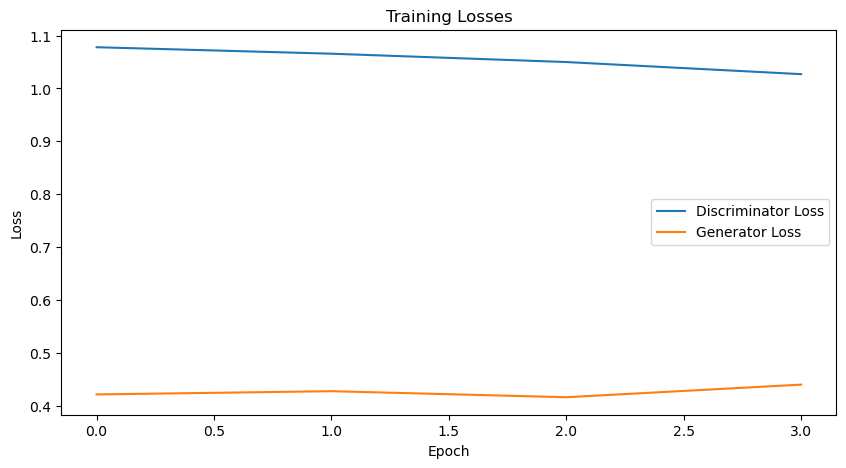

In [6]:
# After training, plot the losses
plot_training_loss(discriminator_losses, generator_losses, save_interval)

# Evaluation

In [ ]:
# Load model
# Hyperparameters
epochs = 4
batch_size = 16
save_interval = 10
sequence_length = 300  # Adjust based on your sequences
latent_dim = 64  # Latent dimension for the generator
num_heads = 4
embed_dim = 256
num_layers = 16
num_layers_g = 16
num_layers_d = 8
ff_dim = 512
dropout_rate=0.3
encoding_size = 3  # Each amino acid is encoded by 3 numbers
with strategy.scope():
    # Build the transformer encoder
    transformer_encoder = build_transformer_encoder(
        sequence_length, num_heads, embed_dim, num_layers, ff_dim, encoding_size)

    # Build the generator
    generator = build_generator(latent_dim, sequence_length, encoding_size)

    # Build and compile the discriminator
    discriminator = build_discriminator(sequence_length, encoding_size)
    discriminator.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Noise input for the generator
    noise = layers.Input(shape=(latent_dim,))
    generated_sequence = generator(noise)

    # Make the discriminator non-trainable when we are training the generator
    discriminator.trainable = False

    # The discriminator takes generated sequences as input and determines validity
    validity = discriminator(generated_sequence)

    # The combined model (stacked generator and discriminator)
    combined = Model(noise, validity)
    combined.compile(optimizer='adam', loss='binary_crossentropy')



# Load weights for the transformer_encoder model
with open('transformer_encoder_weights.pkl', 'rb') as file:
    transformer_encoder_weights = pickle.load(file)
transformer_encoder.set_weights(transformer_encoder_weights)

# Load weights for the generator model
with open('generator_weights.pkl', 'rb') as file:
    generator_weights = pickle.load(file)
generator.set_weights(generator_weights)

# Load weights for the discriminator model
with open('discriminator_weights.pkl', 'rb') as file:
    discriminator_weights = pickle.load(file)
discriminator.set_weights(discriminator_weights)

In [ ]:
# Create a KDTree from the encoding map
def create_kdtree(encoding_map):
    reverse_encoding = {tuple(value): key for key, value in encoding_map.items()}
    encoding_values = np.array(list(reverse_encoding.keys()))
    kdtree = KDTree(encoding_values)
    return kdtree, reverse_encoding, encoding_values

# Update the nearest_amino_acid function to accept encoding_values
def nearest_amino_acid(encoded_vector, kdtree, reverse_encoding, encoding_values):
    dist, ind = kdtree.query([encoded_vector], k=1)
    nearest_vector = encoding_values[ind[0][0]]
    return reverse_encoding[tuple(nearest_vector)]

# When calling generate_sequences, pass encoding_values as well
def generate_sequences(generator, num_sequences, latent_dim, kdtree, reverse_encoding, encoding_values):
    # Generate a batch of noise vectors
    random_latent_vectors = np.random.normal(0, 1, size=(num_sequences, latent_dim))

    # Use the trained generator to generate new sequences
    generated_sequences = generator.predict(random_latent_vectors)

    # Decode the generated sequences
    predicted_sequences = []
    for sequence in generated_sequences:
        predicted_seq = ''
        for encoded_vector in sequence:
            # Pass encoding_values to nearest_amino_acid function
            predicted_seq += nearest_amino_acid(encoded_vector, kdtree, reverse_encoding, encoding_values)
        predicted_sequences.append(predicted_seq)

    return predicted_sequences


In [ ]:
num_sequences = 10000
# Create the KDTree and reverse encoding map
kdtree, reverse_encoding, encoding_values = create_kdtree(encoding_map)

predicted_sequences = generate_sequences(generator, num_sequences, latent_dim, kdtree, reverse_encoding, encoding_values)
output_file_path = "generated_sequences.txt"

# Print the generated sequences to output txt file to upload to UniProt BLAST
with open(output_file_path, "w") as output_file:
    for i, seq in enumerate(predicted_sequences):
        header = f">Generated_sequence_{i+1}\n"
        output_file.write(header)
        output_file.write(seq)
        output_file.write("\n")

In [7]:
# Demo 10 example sequences
num_sequences = 10


# Create the KDTree and reverse encoding map
kdtree, reverse_encoding, encoding_values = create_kdtree(encoding_map)

predicted_sequences = generate_sequences(generator, num_sequences, latent_dim, kdtree, reverse_encoding, encoding_values)

# Print the generated sequences
for i, seq in enumerate(predicted_sequences):
    print(f"Generated sequence {i+1}: {seq}")

1/1 [==============================] - 0s 133ms/step
Generated sequence 1: AUWMAGAUFLGGAAMLRAAAFWWGAAAYFSGAAWFMKAFAFMGAGAMWRSAYFWMGAAFMGNGGMFWRGAAAWGNALUFMFAAYWWAGANYMAAARUWAGGUFWRFAAYFFAAAUFMMAAUWWRKGAFLMMAALMMGRAALMGGAAWWMAAAYWMGAAUFWRGAAYWWGGAYWMWAUUWFRAALMYRAUGYWMAAAAWWAGAAWMRGAUUWRAGAUWNGAAUFMGAAAFWMFAUYWMKAAYWWWAAAWMRUAFLWRAAAFWMGAAUFWGAAAYWRAAAFFWAAAMMWGAALLMKGGALWR
Generated sequence 2: AUFWNAAUFFRGGAAFMAAAUMRNAAAFWGAAAFMAGAAULUGAUAUWRAAUWWMGAALFWGAAAFARAALFMAAAAAMMGAAUYMGAALFMKAAYFFMGAAFFNAAAYFWAAAAMWGAAAFMRAAAFYWRAAUWRRAAAFRRGAALFWAAAAFSGAGAFWAGAAAWMGALAYRGAALWRGAAYWWMGAAMFAGAGUWMKAGAFWKAAAWWWGAAUWMGAUALWRGAUFWFGAGYWMRAALWMGAAAWWGGAUYMMGGAUWRGAAUFMMAAAYWRAAAUWRGAAFFMGAAUFWRGAUYYR
Generated sequence 3: AAFWGAAUFWWRAAYYMAAAFWFGAAUFMRAAAWFMGAALFRGAUAWGRAAUWWRNGAYWKGAAFWWGGAAYRGAAAUWFGAAUFGGAAUWFGAAUYMGAARLFWFAALWARAAUMMNAAAWWRGAAAWMRAAUWWMAAUYWGGAAFWYAAAUFRGAALFWGGAAWFRGAAUYMGAUAWMNGAYUWNGAAYFRGGNYFMNGUARWAGAALWFAAAWFRGAAUFMKAAUWFGRAAFFMAAALFWMAAYWWKAAAYMFKAUFWRGAAUYFMGAAMWMAAUW